In [1]:
# !conda install -c conda-forge tqdm -n TORCH_ENV_NAME
# !pip install torchinfo

import os
import sys
sys.path.append('lib')
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import utils
import hyperparameter
from utils import STOCKS_LIST
from stock_data import stock_data
from RNN import RNN


# Pre-training

## Set hyper parameters

STOCKS: name of stocks to be predicted -> Choose from data


PRECISON: precision of prediction -> 32/64


PRE_PROCESS: Whether to use pre-processed data from data_preprocessing.ipynb -> True/False


RNN_TYPE: type of rnn -> (bi)RNN, (bi)LSTM, (bi)GRU


IN_FEATURES/OUT_FEATURES: features to be input/output of machine -> Open, Close, High, Low


SCALER_NAME: Name of sklearn.preprocessing scaler -> MinMaxScaler, StandardScaler, RobustScaler,...


HIDDEN_SIZE: Size of hidden variables inside RNN/LSTM/GRU module


NUM_LAYERS: Number of stacked layers of RNN/LSTM/GRU module


DROPOUT: drop out rate of NN


PAST_DAYS: Number of days to be used to predict


SUCCESSIVE_DAYS: Number of days to be predicted


OPTIMIZER_NAME: Name of optimizer to be used -> RMSprop, Adam, Adagrad, ...


LEARNING_RATE: learning rate of optimizer


L2_REGULARIZATION: L2 regularization factor for optimizer


LOSS_NAME: Name of loss function -> MSELoss, SmoothL1Loss, ...


SCALER_NAME: name of scaler to normalize data -> 'MinMaxScaler'



In [11]:
#* Set device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(DEVICE))

#* Set hyper parameter
param = hyperparameter.default_parameter()
param.early_stop_delta = 1e-4
param.successive_days = 7
param.update_prefix()

#* Set default precision
torch.set_default_dtype(getattr(torch, 'float' + param.precision))

#* prefix
print(param.prefix)

Using device: cuda:0
AMZN_32_LSTM_OCHL2HL_PD80_SD7_MinMax_NL3_HL200_DO0.1_RMSprop_LR0.0005_RG1e-05_SmoothL1Loss


## Generate dataset

In [12]:
data = stock_data(stocks = param.stocks,
                  in_features=param.in_features,
                  out_features=param.out_features,
                  precision=param.precision,
                  past_days=param.past_days,
                  successive_days=param.successive_days,
                  scaler_name=param.scaler_name,
                  pre_process=True,
                  use_stock_dataset=True,
                  verbose=True
                  )
train_loader = data.get_train_loader(batch_size=32, num_workers=8)
val_loader = data.get_val_loader(batch_size=64)


Finished reading a file data/pre_32/AMZN.parquet.snappy
-----------------------------
Number of train set: 1926 with input: torch.Size([80, 4]) output: torch.Size([7, 2])
Number of validation set: 498 with input: torch.Size([80, 4]) output: torch.Size([7, 2])
Number of test set: 497 with input: torch.Size([80, 4]) output: torch.Size([7, 2])


## Define neural network, loss function, optimizer type

In [13]:
#* Define model
model = RNN(rnn_type=param.rnn_type,
            bidirectional=param.bidirectional,
            in_features=param.in_features,
            out_features=param.out_features,
            successive_days=param.successive_days,
            hidden_size=param.hidden_size,
            num_layers=param.num_layers,
            dropout=param.dropout
            ).to(DEVICE)

#* Initialize epoch, loss, optimizer, loss function
epoch, min_val_loss = 0, np.Inf
train_loss_list, val_loss_list = np.array([]), np.array([])
optimizer = getattr(optim, param.optimizer_name)(params=model.parameters(),
                                           lr=param.learning_rate,
                                           weight_decay=param.L2_regularization)
loss_func = getattr(nn, param.loss_name)(reduction='sum')

#* Summarize the model
example_input, example_output = data.train_dataset[0]
utils.model_summary(model, input_size=example_input.shape, precision=param.precision)


Layer (type:depth-idx)                   Input Shape      Output Shape     Kernel Shape     Param #          Mult-Adds
RNN                                      --               --               --               --               --
├─rnn.weight_ih_l0                                                         [800, 4]
├─rnn.weight_hh_l0                                                         [800, 200]
├─rnn.weight_ih_l1                                                         [800, 200]
├─rnn.weight_hh_l1                                                         [800, 200]
├─rnn.weight_ih_l2                                                         [800, 200]
├─rnn.weight_hh_l2                                                         [800, 200]
├─fc.weight                                                                [14, 200]
├─LSTM: 1-1                              [1, 80, 4]       [1, 80, 200]     --               808,000          64,640,000
│    └─weight_ih_l0                               

## Benchmark
Do not run benchmark unless you re-run the above cell: This will change your model parameter


In [6]:
utils.benchmark(model, loss_func, optimizer, train_loader = train_loader, save_path= os.path.join("profile", param.prefix))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train finished with 4.678942 seconds, 3 epochs, 0.000000 validation loss


## Load model if needed

In [11]:
#* Load model with prefix
# prefix = 'AMZN_32_RNN_OHLC2HL_HS200_NL3_DO0.10_PD80_SD5_LR0.0005_RG1e-05_LFSmoothL1Loss'
prefix = param.prefix
epoch = 48

checkpoint = torch.load(os.path.join('model', prefix + '_{}.pth'.format(epoch)), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']
train_loss_list = checkpoint['train_loss_list']
val_loss_list = checkpoint['val_loss_list']
min_val_loss = val_loss_list[-1]
test_mse = checkpoint['test_mse']
print("Loaded model has average test MSE: {:.6f}, recurrent test MSE: {:.6f}".format(test_mse[0], test_mse[1]))

try:
    print("REMARK:", checkpoint['Remark'])
except KeyError:
    pass


Loaded model has average test MSE: 363.202625, recurrent test MSE: 392.129028
REMARK: Early stopped


# Training

In [14]:
train_loss, val_loss, best = utils.train(model,
                                         max_epoch=100,
                                         loss_func=loss_func,
                                         optimizer=optimizer,
                                         train_loader=train_loader,
                                         val_loader=val_loader,
                                         early_stop_patience=param.early_stop_patience,
                                         early_stop_delta=param.early_stop_delta,
                                         min_val_loss=min_val_loss,
                                         verbose=1
                                         )

#* Load best model state and epoch number
if best[0] is None:     # Only when loaded model and newly trained is already overfitted
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(best[0])
best_epoch = best[1]

#* Update epoch and loss lists, accuracy lists
epoch += best_epoch + 1
train_loss_list = np.concatenate((train_loss_list,
                                  train_loss[:best_epoch + 1 + param.early_stop_patience]))
val_loss_list = np.concatenate((val_loss_list,
                                val_loss[:best_epoch + 1 + param.early_stop_patience]))


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1	Validation loss decreased (inf --> 0.030987). Saving model
Epoch 2	Validation loss decreased (0.030987 --> 0.022149). Saving model
Epoch 3	Early Stopping counter: 1/10
Epoch 4	Early Stopping counter: 2/10
Epoch 5	Early Stopping counter: 3/10
Epoch 6	Validation loss decreased (0.022149 --> 0.019960). Saving model
Epoch 7	Early Stopping counter: 1/10
Epoch 8	Validation loss decreased (0.019960 --> 0.018952). Saving model
Epoch 9	Early Stopping counter: 1/10
Epoch 10	Validation loss decreased (0.018952 --> 0.018191). Saving model
Epoch 11	Early Stopping counter: 1/10
Epoch 12	Early Stopping counter: 2/10
Epoch 13	Validation loss decreased (0.018191 --> 0.017838). Saving model
Epoch 14	Validation loss decreased (0.017838 --> 0.017343). Saving model
Epoch 15	Early Stopping counter: 1/10
Epoch 16	Early Stopping counter: 2/10
Epoch 17	Validation loss decreased (0.017343 --> 0.016390). Saving model
Epoch 18	Validation loss decreased (0.016390 --> 0.016225). Saving model
Epoch 19	Early 

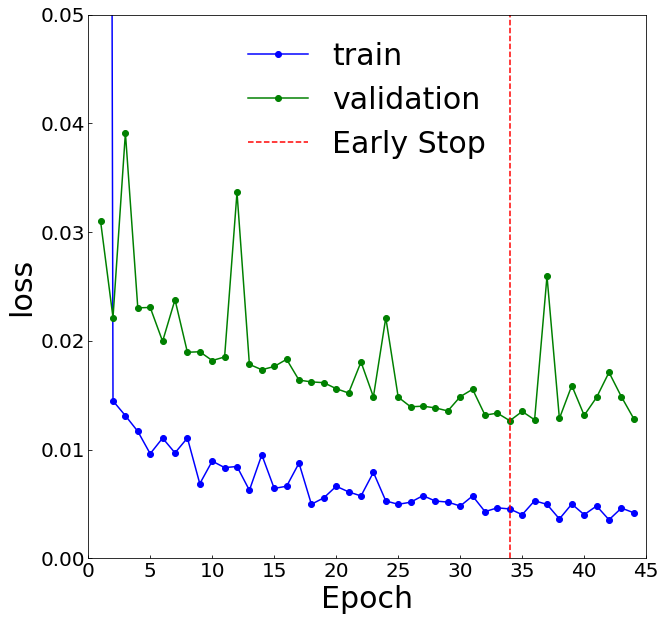

In [17]:
ax = utils.plot_loss(train_loss_list, val_loss_list, stop_epoch=epoch)
_ = ax.set_xlim([0, epoch + param.early_stop_patience + 1])
_ = ax.set_ylim([0, 0.05])


# Test

Average test finished with 2.84 seconds
MSE: 277.197670
Recurrent test finished with 2.82 seconds
MSE: 173.697571


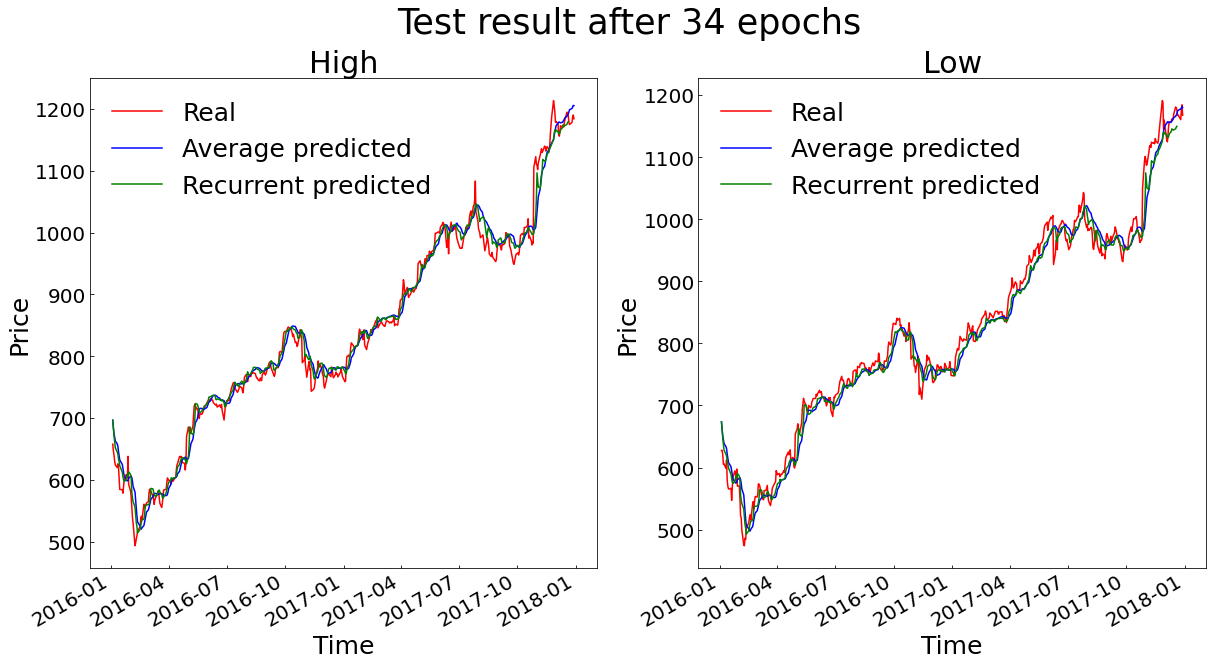

In [18]:
avg_prediction, avg_test_loss, avg_test_mse = utils.average_test(model, data,
                                                                 loss_func=loss_func,
                                                                 verbose=True)
rec_prediction, rec_test_loss, rec_test_mse = utils.recurrent_test(model, data,
                                                                   loss_func=loss_func,
                                                                   verbose=True)

ax = utils.plot_prediction(data=data,
                           epoch=epoch,
                           #   save_path=os.path.join('fig', PREFIX + "_prediction.png"),
                           avg_prediction=avg_prediction,
                           recurrent_prediction=rec_prediction)


# Save the model

In [19]:
#* Save the model with current state
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'train_loss_list': train_loss_list[:epoch],
            'val_loss_list': val_loss_list[:epoch],
            'Remark': 'Early stopped',
            'test_mse': (avg_test_mse, rec_test_mse)
            },
           os.path.join('model', param.prefix + '_{}.pth'.format(epoch)))

print("Saved model", param.prefix + '_{}.pth'.format(epoch))

Saved model AMZN_32_LSTM_OCHL2HL_PD80_SD7_MinMax_NL3_HL200_DO0.1_RMSprop_LR0.0005_RG1e-05_SmoothL1Loss_34.pth


# Find best model

In [10]:
best_MSE = np.Inf
for file in os.listdir('model'):
    if 'AMZN' in file and 'SD{}_'.format(param.successive_days) in file:
        checkpoint = torch.load(os.path.join('model', file))
        try:
            test_mse = min(checkpoint['test_mse'][0], checkpoint['test_mse'][1])
            if test_mse < best_MSE:
                best_name = file
                best_MSE = test_mse
        except KeyError:
            print("No MSE value at", file)
print(best_name, best_MSE)

AMZN_32_LSTM_OCHL2HL_PD80_SD1_MinMax_NL3_HL200_DO0.1_RMSprop_LR0.0005_RG1e-05_SmoothL1Loss_75.pth 95.38703918457031
